In [ ]:
from dotenv import load_dotenv
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display

load_dotenv()

llm = init_chat_model("anthropic:claude-sonnet-4-20250514")

class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response"
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str

def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}

def router(state: State):
    message_type = state.get("message_type", "logical")
    if message_type == "emotional":
        return {"next": "therapist"}
    return {"next": "logical"}

def therapist_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's messages
        show empathy, validate their feelings, and help them process their emotions. Ask thoughtful questions
        to help them explore their feelings more deeply. Avoid giving logical solutions unless explicitly asked."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}



def logical_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are a purely logical assistant. Focus on only facts and information. Provide
        clear, concise answers based on logic and evidence. Do not address emotions or provide emotional support.
        Be direct and straightforward in your responses."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {"therapist": "therapist", "logical": "logical"}
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)

graph = graph_builder.compile()

def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")

if __name__ == "__main__":
    run_chatbot()

Assistant: I'm really sorry to hear that you're feeling sad right now. That sounds painful, and I want you to know that it's completely okay to feel this way - sadness is a natural and valid emotion that we all experience.

I'm here with you in this moment. Would you feel comfortable sharing what's been weighing on your heart lately? Sometimes just putting those feelings into words can help, even if it doesn't take the sadness away right away.

How long have you been carrying this sadness with you?


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0: all messages must have non-empty content except for the optional final assistant message'}, 'request_id': 'req_011CScpKhVgcq23TUjmjYf53'}

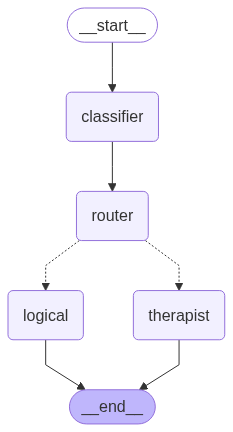

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass